# 1. Introuction

 This notebook outlines the creation, compilation, and training of a SWIN Transformer network to classify 101 types of food. Two models will be trained, a model for 101 classes and another one supporting an extra class called "unknown". This class was created using images from the [iFood-2019 dataset](https://www.kaggle.com/competitions/ifood-2019-fgvc6/data) that contains 251 food types. In the other trained models, PyTorch's pretrained weights will be used to initialize the models and no transfer learning will be applied. 

# 2. Importing Libraries

In [3]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Trainer, sec_to_min_sec
from modules.scheduler import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders
#from modules.scheduler import WarmupCosineAnnealingLR

# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Sun Jan 19 00:52:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   45C    P8             12W /  200W |    1445MiB /  12282MiB |      4%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

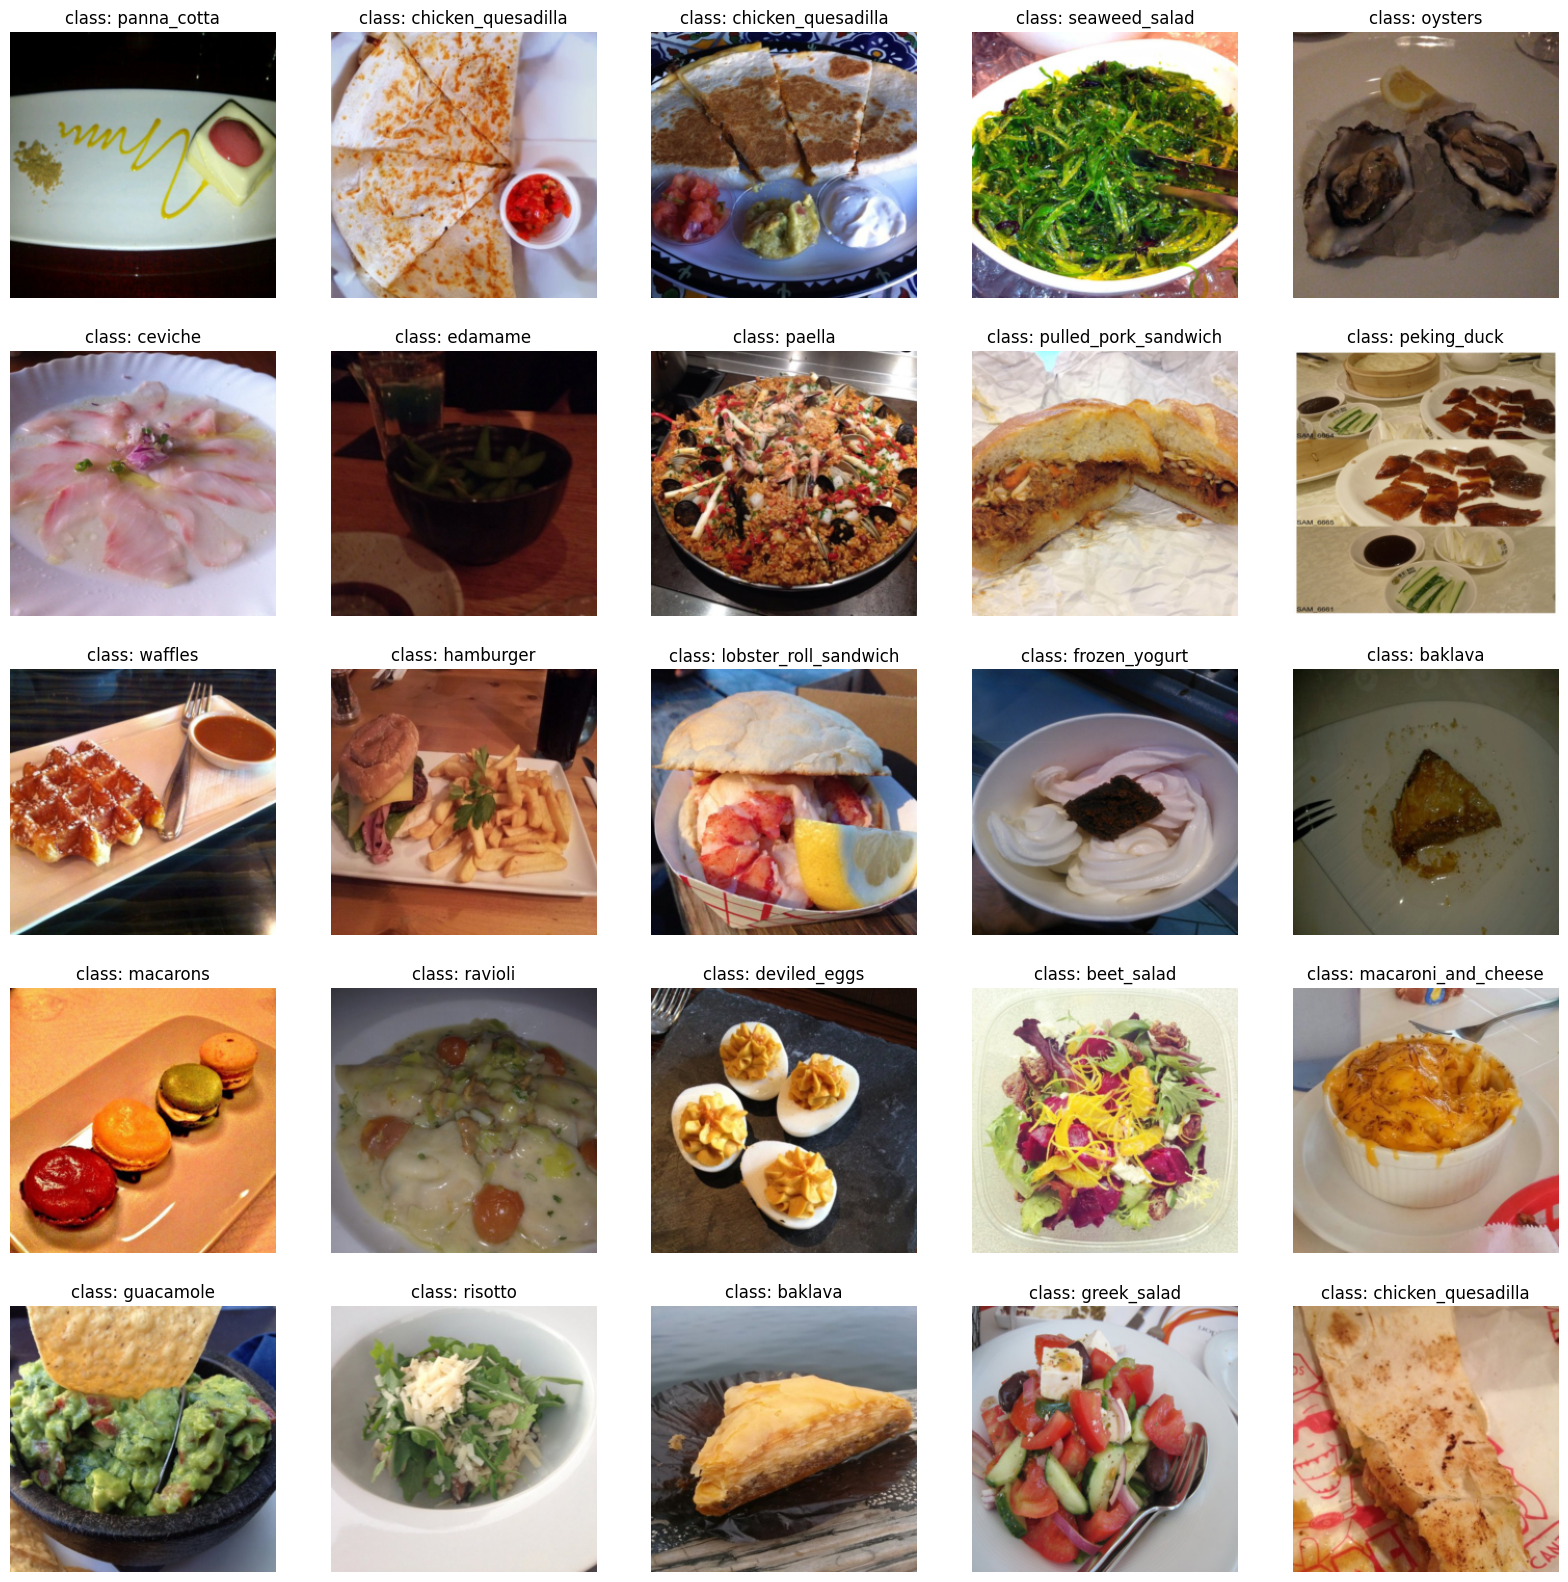

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Default PyTorch's ViT-Base/16-224

In [ ]:
# Create transforms
IMG_SIZE_1 = 384
IMG_SIZE_2 = 384
manual_transforms_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.RandomCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

manual_transforms_test = v2.Compose([    
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

# Create dataloaders
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = create_dataloaders(    
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_train,
    test_transform=manual_transforms_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# Copy weights from torchvision.models
set_seeds(SEED)

# Instantiate the model
model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1).to(device)
model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Unfreeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = True

# Compile model
model = torch.compile(model, backend="aot_eager")

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [ ]:
# Train the model
model_type="vitb384_101_2025-01-18"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2,
    )

In [ ]:
results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0      1    2.041897   0.642894             0.114982     2330.527193   
1      2    1.510450   0.787302             0.026759     2271.655912   
2      3    1.366547   0.828383             0.015279     2286.242224   
3      4    1.271639   0.856054             0.009707     2312.965180   
4      5    1.191092   0.878885             0.006163     2279.843962   
5      6    1.125374   0.899498             0.003912     2333.301921   
6      7    1.069926   0.916658             0.002497     2342.706653   
7      8    1.031505   0.929527             0.001649     2317.135618   
8      9    1.003434   0.938503             0.001233     2341.246624   
9     10    0.986894   0.944892             0.000960     2321.385335   

   test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0   1.330157  0.848876            0.008629     361.311990  0.000100  
1   1.200258  0.876148            0.005236     329.092049  0.000098  
2   1.147945  0.891545            0.004541     333.511352  0.000091  
3   1.127565  0.896414            0.004394     333.702853  0.000080  
4   1.095416  0.902035            0.003844     327.879499  0.000066  
5   1.076820  0.908447            0.003301     352.513170  0.000051  
6   1.055183  0.913949            0.002811     339.093357  0.000035  
7   1.045623  0.916838            0.002560     336.147734  0.000021  
8   1.041611  0.919055            0.002433     336.582034  0.000010  
9   1.037223  0.919767            0.002413     336.133252  0.000003

Epoch: 20 | train_loss: 0.8196 | train_acc: 0.9900 | fpr_at_recall: 0.0000 | train_time: 15m47s | test_loss: 1.0541 | test_acc: 0.9205 | fpr_at_recall: 0.0040 | test_time: 2m48s | lr: 0.0000016094


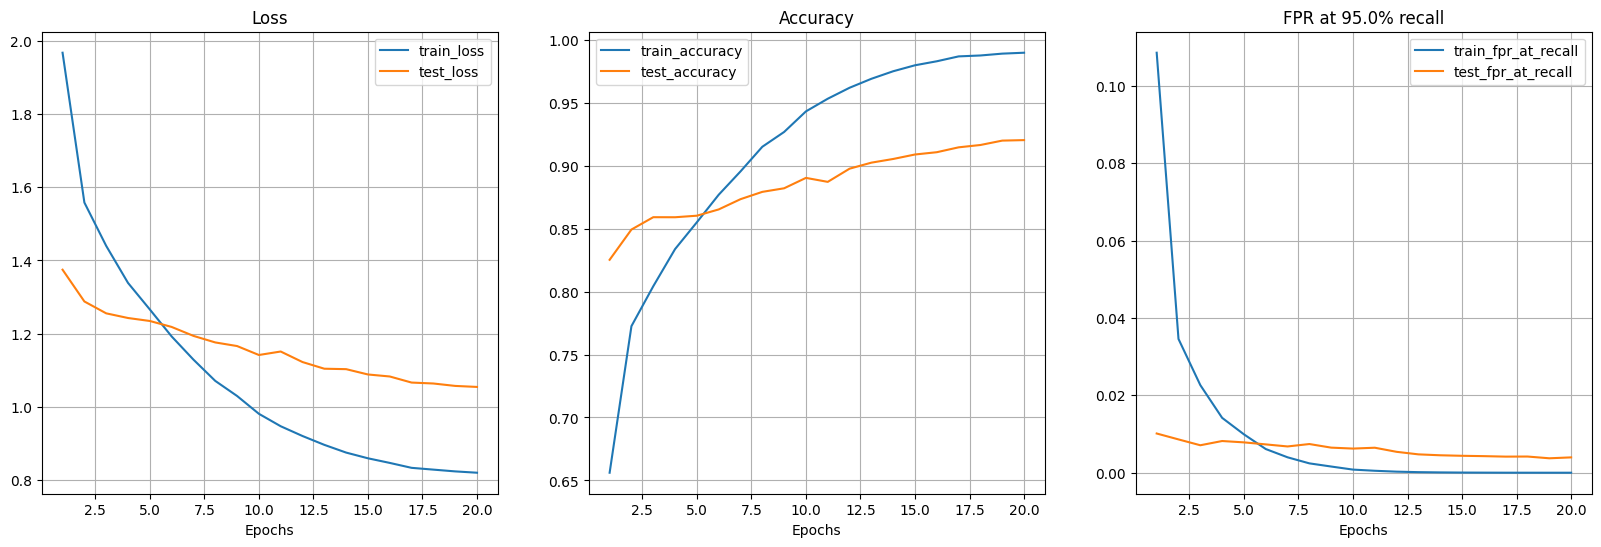

[INFO] Saving model to: ..\models\vitb384_101_2025-01-19_loss.pth
[INFO] Saving model to: ..\models\vitb384_101_2025-01-19_acc.pth
[INFO] Saving model to: ..\models\vitb384_101_2025-01-19.pth


In [5]:
# Train the model
model_type="vitb384_101_2025-01-19"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
swinb_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=swinb_model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2,
    )

In [6]:
results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0       1    1.967898   0.656100             0.108569      973.143182   
1       2    1.558291   0.772606             0.034580      958.487888   
2       3    1.439812   0.804314             0.022655      967.897381   
3       4    1.338551   0.833866             0.014193      967.584996   
4       5    1.266015   0.855196             0.009926      955.975376   
5       6    1.192251   0.877059             0.006133      949.374278   
6       7    1.128824   0.895609             0.003992      949.921112   
7       8    1.070666   0.915197             0.002425      949.032649   
8       9    1.029428   0.926973             0.001608      950.075284   
9      10    0.980693   0.943333             0.000813      948.291191   
10     11    0.946662   0.953389             0.000512      947.872195   
11     12    0.919963   0.962112             0.000283      946.714551   
12     13    0.895799   0.969234             0.000156      947.847862   
13     14    0.874648   0.975230             0.000088      948.569089   
14     15    0.859019   0.979980             0.000048      945.721391   
15     16    0.846408   0.983161             0.000029      947.269976   
16     17    0.832937   0.987041             0.000015      946.565560   
17     18    0.828054   0.987767             0.000012      945.269662   
18     19    0.823221   0.989231             0.000009      946.960502   
19     20    0.819587   0.989957             0.000008      947.018220   

    test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0    1.374645  0.825356            0.010147     187.605644  0.000100  
1    1.287812  0.849407            0.008617     169.665606  0.000099  
2    1.255348  0.859217            0.007106     175.528299  0.000098  
3    1.242598  0.859177            0.008201     171.095976  0.000095  
4    1.234453  0.860403            0.007853     170.635041  0.000091  
5    1.218168  0.865388            0.007330     168.710067  0.000086  
6    1.193736  0.873536            0.006798     168.416318  0.000080  
7    1.175790  0.879351            0.007423     168.666870  0.000073  
8    1.165926  0.882199            0.006492     168.286422  0.000066  
9    1.141464  0.890467            0.006249     168.574965  0.000058  
10   1.150970  0.887302            0.006469     168.530871  0.000051  
11   1.122191  0.897785            0.005409     168.145020  0.000043  
12   1.103947  0.902571            0.004752     169.267200  0.000035  
13   1.102748  0.905498            0.004516     168.669828  0.000028  
14   1.088202  0.909059            0.004383     168.051891  0.000021  
15   1.082713  0.910878            0.004293     169.252006  0.000015  
16   1.066091  0.914755            0.004169     169.323018  0.000010  
17   1.063527  0.916614            0.004192     167.976537  0.000006  
18   1.056919  0.920095            0.003739     168.276888  0.000003  
19   1.054136  0.920491            0.003972     168.147068  0.000002

In [5]:
results = pd.read_csv(os.path.join(MODEL_DIR, "vitb384_101_2025-01-19.csv"))
training_time = sec_to_min_sec(results["train_time [s]"].mean() + results["test_time [s]"].mean())
print(f"training time: {training_time}")

training time: 18m42s
